In [394]:
import pandas as pd
from zipfile import ZipFile
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px

In [6]:
zip_name = "lastfm-dataset-1K.zip"
with ZipFile(zip_name, 'r') as z:
    folder = "lastfm-dataset-1K/"

    #Read song csv
    song_file = folder +"userid-timestamp-artid-artname-traid-traname.tsv"
    songs = pd.read_csv(z.open(song_file), sep='\t', error_bad_lines=False, 
                    header=None, parse_dates=[1], 
                    names=['user_id', 'timestamp', 'artist_id', 'artist_name', 
                    'track_id', 'track_name'],
                    dtype={0:'category', 2:'category',3:'category',4:'category',5:'category'})

In [289]:
songs.head()

,user_id,timestamp,artist_id,artist_name,track_id,track_name
0,user_000001,2009-05-04 23:08:57+00:00,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04 13:54:10+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04 13:52:04+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04 13:42:52+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04 13:42:11+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)


In [391]:
users = songs.user_id.unique()[:10]
sample = songs[songs.user_id.isin(users)]

**TODO** try merging track names with the same track id

In [399]:
def get_embeddings(df, min_count=5):
    df = df.sort_values("timestamp")
    df = df[~df.track_name.isna()]
    df["song_id"]= df.artist_name.cat.codes.astype("int64") * df.track_name.nunique() \
                        + df.track_name.cat.codes
    print(f"Number of entries: {len(sample)}")
    assert len(df.query("song_id < 0")) == 0 #Check underflow
    
    document = df.groupby("user_id").agg(sentences=("song_id", list))
    model = Word2Vec(document.sentences.values, min_count=min_count)
    
    emb_vectors = {}
    for n in model.wv.index_to_key:
        emb_vectors[n] = model.wv[n]
    print(f"Number of song embeddings: {len(emb_vectors)}")
    return df, emb_vectors

In [400]:
sample, emb_vectors = get_embeddings(sample)

Number of entries: 212886
Number of song embeddings: 9904


In [411]:
df = sample
top_n = 10
top_artists = list(df[df.song_id.isin(emb_vectors.keys())].artist_name.value_counts()\
        .to_frame().head(top_n).index.codes)
min_count_df = pd.DataFrame(data=emb_vectors.keys(), columns=["song_id"])
min_count_df = min_count_df.merge(sample[['song_id', 'artist_name']].drop_duplicates(), how='left')
song_artist = min_count_df.artist_name.astype(str)
song_artist.where(song_artist.isin(top_artists), 'other').head()

0    other
1    other
2    other
3    other
4    other
Name: artist_name, dtype: object

In [414]:
def plot_embeddings_2D(emb_vectors, song_artists, top_n):
    # apply PCA
    sg_df = pd.DataFrame(emb_vectors).T
    pca = PCA(n_components=2)
    components = pca.fit_transform(sg_df)
    x, y = components[0], components[1]

    fig, ax = plt.subplots(figsize=(15, 8))
    plot_df = pd.DataFrame(data=components)
    plot_df['top_artist'] = song_artists
    plot_df = plot_df.query("top_artist != 'others'")
    sns.scatterplot(data=plot_df, x=0, y=1, hue="top_artist")
    plt.xlabel('PCA first dimension')
    plt.ylabel('PCA second dimension')
    plt.title(f"Skipgram embeddings PCA 2D visualization for top {top_n} artists")
    plt.show()
    
def plot_top_artist(df, emb_vectors, top_n=10):
    top_artists = list(df[df.song_id.isin(emb_vectors.keys())].artist_name.value_counts()\
        .to_frame().head(top_n).index.codes)
    df["top_artist"] = 'others'
    for i, artist in enumerate(top_artists):
        df.top_artist.where(df.artist_name.cat.codes != artist, df.artist_name, inplace=True)
        
    min_count_df = pd.DataFrame(data=emb_vectors.keys(), columns=["song_id"])
    song_artists = pd.merge(min_count_df, df[['song_id', 'top_artist']].drop_duplicates(), how='left')\
                            .top_artist.values

    plot_embeddings_2D(emb_vectors, song_artists, top_n)

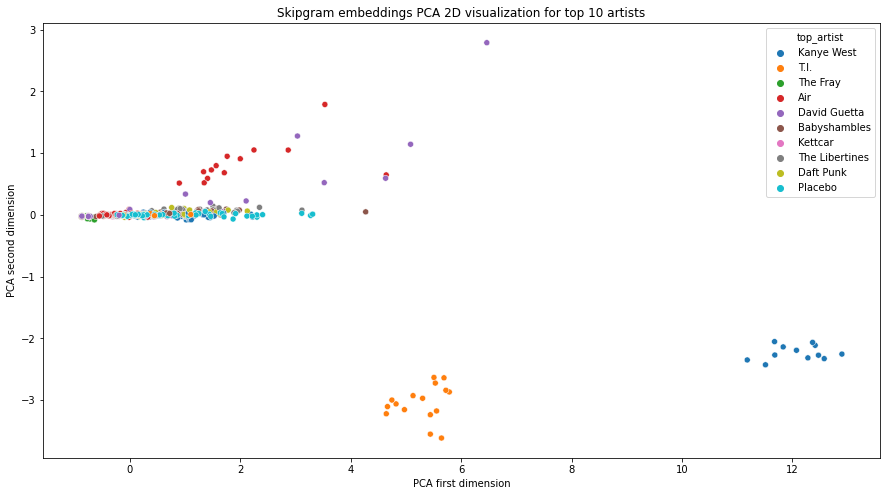

In [415]:
plot_top_artist(sample, emb_vectors)

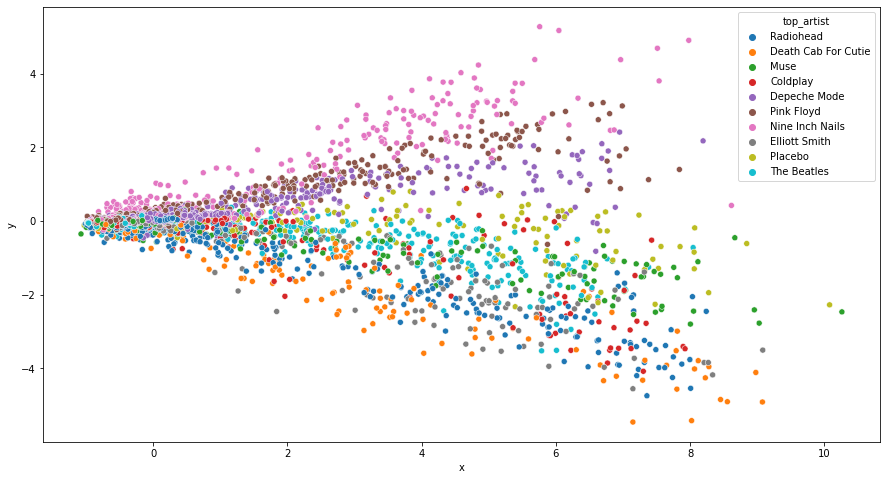

In [389]:
plot_embeddings_2D(emb_vectors)